# Анализ температурных данных и мониторинг текущей температуры

**Цель проекта:**  
Разработка решения для анализа исторических температурных данных и мониторинга текущей температуры в выбранных городах с использованием OpenWeatherMap API. Проект включает проведение анализа временных рядов, выявление аномалий, создание сезонных профилей и разработку интерактивного веб-приложения.

---

## Выполненные задачи

### 1. Анализ временных рядов исторических данных:
- Вычислено скользящее среднее с окном в 30 дней для сглаживания температурных колебаний.
- Рассчитаны средние значения температуры и стандартное отклонение для каждого сезона в каждом городе.
- Определены аномалии температуры, которые выходят за пределы диапазона:  
  $$ \text{скользящее среднее} \pm 2\sigma $$
- Построены долгосрочные тренды изменения температуры с использованием линейной регрессии.
- Исследована эффективность параллельной обработки данных:
  - Сравнена скорость выполнения анализа данных при последовательной и параллельной обработке с использованием `multiprocessing` и `concurrent.futures`.

### 2. Мониторинг текущей температуры через OpenWeatherMap API:
- Интеграция с OpenWeatherMap API для получения текущей температуры в выбранных городах.
- Реализована проверка, является ли текущая температура нормальной для текущего сезона на основе исторических данных.
- Сравнены подходы синхронного и асинхронного выполнения запросов к API для оптимизации времени отклика.

### 3. Разработка интерактивного веб-приложения:
- Реализовано приложение на Streamlit, предоставляющее пользователю следующие возможности:
  - Загрузка файла с историческими данными в формате CSV.
  - Выбор города из выпадающего списка для анализа.
  - Отображение описательной статистики по историческим данным, включая средние, минимальные и максимальные значения температуры.
  - Построение временного ряда с выделением аномалий (точками другого цвета).
  - Визуализация сезонных профилей с указанием среднего значения и стандартного отклонения.
- Подключена форма для ввода API-ключа OpenWeatherMap. Реализована проверка валидности ключа с выводом сообщений об ошибках в формате JSON.
- Реализован вывод текущей температуры и её сравнение с историческим нормальным диапазоном.

---

## Используемые данные
Исторические данные о температуре содержались в файле `temperature_data.csv`, включающем следующие столбцы:
- `city`: Название города.
- `timestamp`: Дата в формате `YYYY-MM-DD`.
- `temperature`: Среднесуточная температура (в °C).
- `season`: Сезон года (зима, весна, лето, осень).

---

## Технологии и инструменты
- **Язык программирования:** Python
- **Библиотеки:** Pandas, NumPy, Matplotlib, Plotly, Streamlit, aiohttp, requests, scikit-learn
- **Параллельная обработка:** `multiprocessing`, `concurrent.futures`
- **API:** OpenWeatherMap
- **Деплой:** Streamlit Cloud

---

## Результаты
- Проанализированы исторические данные о температуре для выявления аномалий и сезонных закономерностей.
- Разработано интерактивное веб-приложение для визуализации данных и мониторинга текущей температуры.
- Проведён сравнительный анализ подходов синхронного и асинхронного выполнения запросов, выбраны оптимальные решения.
- Решение успешно развернуто на платформе Streamlit Cloud.

---

## Ссылки
- **Приложение:** [Развёрнутое приложение на Streamlit Cloud](ссылка-на-приложение)
- **Код проекта:** [Репозиторий GitHub](ссылка-на-репозиторий)

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import time
import requests
import aiohttp
import asyncio
import nest_asyncio

### Генерация данных и сохранение их в файл temperature_data.csv

In [2]:
# Реальные средние температуры (примерные данные) для городов по сезонам
seasonal_temperatures = {
    "New York": {"winter": 0, "spring": 10, "summer": 25, "autumn": 15},
    "London": {"winter": 5, "spring": 11, "summer": 18, "autumn": 12},
    "Paris": {"winter": 4, "spring": 12, "summer": 20, "autumn": 13},
    "Tokyo": {"winter": 6, "spring": 15, "summer": 27, "autumn": 18},
    "Moscow": {"winter": -10, "spring": 5, "summer": 18, "autumn": 8},
    "Sydney": {"winter": 12, "spring": 18, "summer": 25, "autumn": 20},
    "Berlin": {"winter": 0, "spring": 10, "summer": 20, "autumn": 11},
    "Beijing": {"winter": -2, "spring": 13, "summer": 27, "autumn": 16},
    "Rio de Janeiro": {"winter": 20, "spring": 25, "summer": 30, "autumn": 25},
    "Dubai": {"winter": 20, "spring": 30, "summer": 40, "autumn": 30},
    "Los Angeles": {"winter": 15, "spring": 18, "summer": 25, "autumn": 20},
    "Singapore": {"winter": 27, "spring": 28, "summer": 28, "autumn": 27},
    "Mumbai": {"winter": 25, "spring": 30, "summer": 35, "autumn": 30},
    "Cairo": {"winter": 15, "spring": 25, "summer": 35, "autumn": 25},
    "Mexico City": {"winter": 12, "spring": 18, "summer": 20, "autumn": 15},
}

# Сопоставление месяцев с сезонами
month_to_season = {12: "winter", 1: "winter", 2: "winter",
                   3: "spring", 4: "spring", 5: "spring",
                   6: "summer", 7: "summer", 8: "summer",
                   9: "autumn", 10: "autumn", 11: "autumn"}

# Генерация данных о температуре
def generate_realistic_temperature_data(cities, num_years=10):
    dates = pd.date_range(start="2010-01-01", periods=365 * num_years, freq="D")
    data = []

    for city in cities:
        for date in dates:
            season = month_to_season[date.month]
            mean_temp = seasonal_temperatures[city][season]
            # Добавляем случайное отклонение
            temperature = np.random.normal(loc=mean_temp, scale=5)
            data.append({"city": city, "timestamp": date, "temperature": temperature})

    df = pd.DataFrame(data)
    df['season'] = df['timestamp'].dt.month.map(lambda x: month_to_season[x])
    return df

# Генерация данных
data = generate_realistic_temperature_data(list(seasonal_temperatures.keys()))
data.to_csv('temperature_data.csv', index=False)

## 1. Анализ временных рядов

### 1.1 Загрузка файла temperature_data.csv

In [3]:
df = pd.read_csv('temperature_data.csv', parse_dates=['timestamp'])

df

,city,timestamp,temperature,season
0,New York,2010-01-01,-2.516960,winter
1,New York,2010-01-02,-0.336795,winter
2,New York,2010-01-03,-0.800767,winter
3,New York,2010-01-04,-1.993707,winter
4,New York,2010-01-05,3.143137,winter
...,...,...,...,...
54745,Mexico City,2019-12-25,7.991507,winter
54746,Mexico City,2019-12-26,17.841231,winter
54747,Mexico City,2019-12-27,7.860614,winter
54748,Mexico City,2019-12-28,12.553130,winter


### 1.2 Анализ и графики

In [4]:
# Фильтр для одного города
# Пример: Нью Йорк
city = "New York"
city_data = df[df['city'] == city].copy()

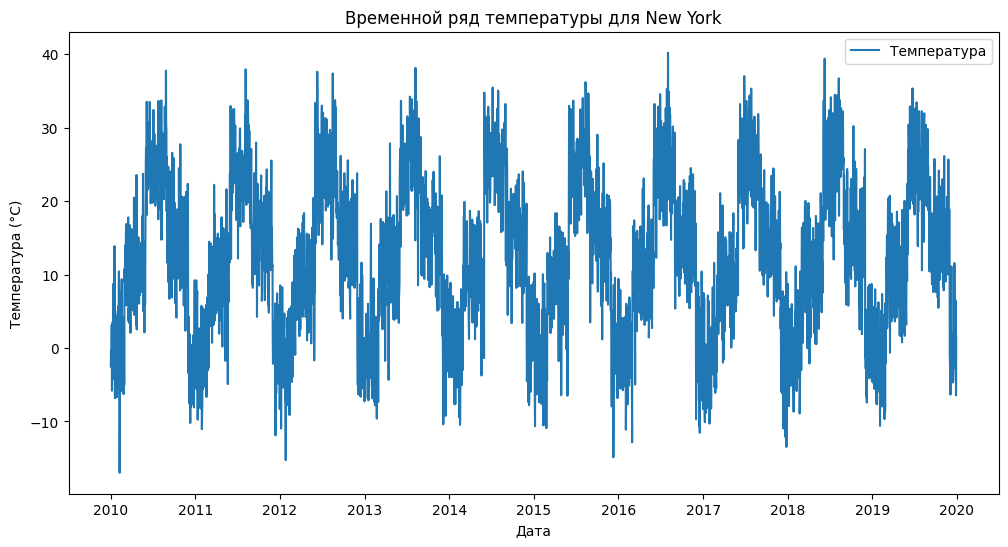

In [5]:
# График временного ряда температуры
plt.figure(figsize=(12, 6))
plt.plot(city_data['timestamp'], city_data['temperature'], label='Температура')
plt.title(f'Временной ряд температуры для {city}')
plt.xlabel('Дата')
plt.ylabel('Температура (°C)')
plt.legend()
plt.show()

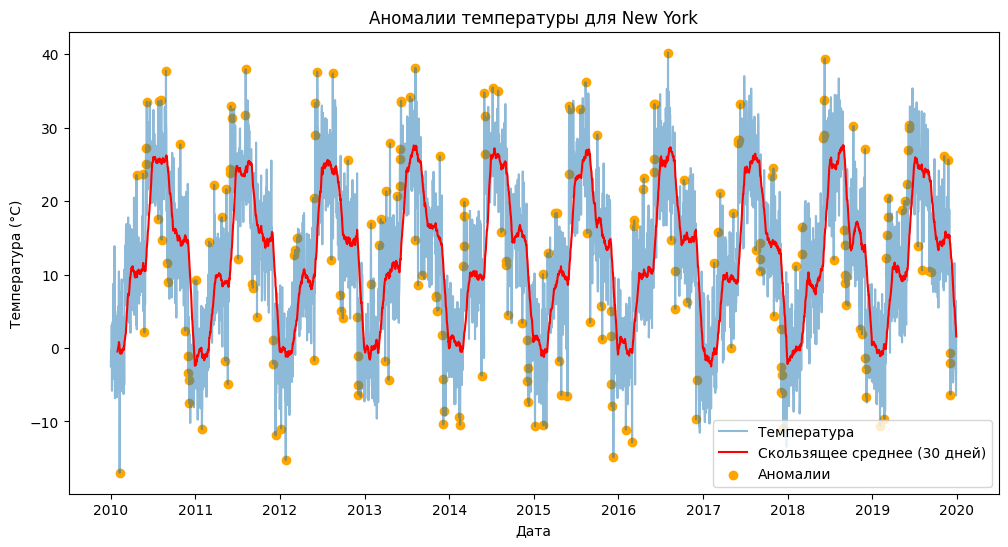

In [6]:
# Вычисляем скользящее среднее с окном 30 дней
city_data['moving_avg'] = city_data['temperature'].rolling(window=30).mean()

# Вычисляем стандартное отклонение с окном 30 дней
city_data['std_dev'] = city_data['temperature'].rolling(window=30).std()

# Выявляем аномалии
lower_bound = city_data['temperature'] > city_data['moving_avg'] + 2 * city_data['std_dev']
upper_bound = city_data['temperature'] < city_data['moving_avg'] - 2 * city_data['std_dev']
city_data['anomaly'] = lower_bound | upper_bound

# Добавляем к имеющемуся графику скользящее среднее
plt.figure(figsize=(12, 6))
plt.plot(city_data['timestamp'], city_data['temperature'], alpha=0.5, label='Температура')
plt.plot(city_data['timestamp'], city_data['moving_avg'], color='red', label='Скользящее среднее (30 дней)')

# Добавляем аномалии
anomalies = city_data[city_data['anomaly']]
plt.scatter(anomalies['timestamp'], anomalies['temperature'], color='orange', label='Аномалии')

plt.title(f'Аномалии температуры для {city}')
plt.xlabel('Дата')
plt.ylabel('Температура (°C)')
plt.legend()
plt.show()

### 1.3 Cравнение скорости последовательного и параллельного исполнения кода для анализа городов из датасета:

In [7]:
def analyze_city(city):
    city_data = df[df['city'] == city].copy()

    # Скользящее среднее, стандартное отклонение и аномалии
    city_data['moving_avg'] = city_data['temperature'].rolling(window=30).mean()
    city_data['std_dev'] = city_data['temperature'].rolling(window=30).std()
    upper_bound = city_data['temperature'] > city_data['moving_avg'] + 2 * city_data['std_dev']
    lower_bound = city_data['temperature'] < city_data['moving_avg'] - 2 * city_data['std_dev']
    city_data['anomaly'] = lower_bound | upper_bound
    anomalies = city_data[city_data['anomaly']]

    # Группировка по сезону для профиля
    seasonal_stats = city_data.groupby('season')['temperature'].agg(['mean', 'std']).reset_index()

    # Тренд (регрессия)
    city_data['timestamp_ordinal'] = city_data['timestamp'].map(pd.Timestamp.toordinal)
    X = city_data[['timestamp_ordinal']].dropna()
    y = city_data['temperature'].dropna()
    model = LinearRegression()
    model.fit(X, y)
    trend = 'positive' if model.coef_[0] > 0 else 'negative'

    # Средняя, min, max температуры
    avg_temp = city_data['temperature'].mean()
    min_temp = city_data['temperature'].min()
    max_temp = city_data['temperature'].max()

    # Возврат результатов
    return {
        'city': city,
        'average_temp': avg_temp,
        'min_temp': min_temp,
        'max_temp': max_temp,
        'seasonal_profile': seasonal_stats,
        'trend': trend,
        'anomalies': anomalies
    }

#### 1.3.1 Последовательное исполнение

In [8]:
time_start1 = time.time()

results = []
for city in df['city'].unique():
    results.append(analyze_city(city))

time_finish1 = time.time()

In [18]:
import os
cpu_count = os.cpu_count()
print(f'Количество ядер процессора: {cpu_count}')

Количество ядер процессора: 2


#### 1.3.2 Параллельное исполнение (multiprocessing)

In [10]:
from multiprocessing import Pool

time_start2 = time.time()

if __name__ == '__main__':
    with Pool(processes=2) as pool:  # Используем 2 процесса
        results = pool.map(analyze_city, df['city'].unique())

time_finish2 = time.time()

#### 1.3.3 Параллельное исполнение (concurrent.futures)

In [11]:
from concurrent.futures import ThreadPoolExecutor

time_start3 = time.time()

if __name__ == '__main__':
    with ThreadPoolExecutor(max_workers=2) as executor:  # Используем 2 потока
        results = list(executor.map(analyze_city, df['city'].unique()))

time_finish3 = time.time()

#### 1.3.4 Вывод результатов

In [12]:
# Пример обработки результата для одного города
example_result = results[0]  # Результат для первого города
print(f"Город: {example_result['city']}")
print(f"Средняя температура: {example_result['average_temp']:.2f}")
print(f"Min температура: {example_result['min_temp']:.2f}")
print(f"Max температура: {example_result['max_temp']:.2f}")
print(f"Тренд: {example_result['trend']}")
print('')
print(f"Аномалии (первые 5 точек):")
print(example_result['anomalies'].head())
print('')
print("Сезонный профиль:")
print(example_result['seasonal_profile'])

Город: New York
Средняя температура: 12.53
Min температура: -16.98
Max температура: 40.19
Тренд: positive

Аномалии (первые 5 точек):
         city  timestamp  temperature  season  moving_avg   std_dev  anomaly
38   New York 2010-02-08   -16.975921  winter   -0.138577  6.390204     True
111  New York 2010-04-22    23.547698  spring   10.389438  5.108299     True
139  New York 2010-05-20    23.702750  spring   11.440421  4.904713     True
145  New York 2010-05-26     2.118724  spring   10.637780  4.203698     True
151  New York 2010-06-01    25.071205  summer   11.066408  5.098298     True

Сезонный профиль:
   season       mean       std
0  autumn  15.038620  4.958369
1  spring   9.851072  4.912205
2  summer  25.213018  4.833250
3  winter  -0.213745  4.908585


In [13]:
print(f'Время последовательного исполнения: {time_finish1 - time_start1:.4f} секунд')
print(f'Время параллельного исполнения (multiprocessing): {time_finish2 - time_start2:.4f} секунд')
print(f'Время параллельного исполнения (concurrent.futures): {time_finish3 - time_start3:.4f} секунд')

Время последовательного исполнения: 1.0824 секунд
Время параллельного исполнения (multiprocessing): 0.8467 секунд
Время параллельного исполнения (concurrent.futures): 0.7168 секунд


#### 1.3.5 Обоснование результатов

Более высокая скорость параллельного исполнения в данном примере может быть обусловлена тем, что:

- обработка данных для каждого города становится достаточно сложной и объемной, что делает последовательный подход менее эффективным.

- параллельные подходы лучше используют ресурсы системы, позволяя обрабатывать данные для нескольких городов одновременно.

При этом многопоточность остается эффективнее многопроцессности, так как потоки работают внутри одного процесса, избегая затрат на создание и управление отдельными процессами.


## 2. Мониторинг текущей температуры

### 2.1 Получение текущей температуры выбранного города через OpenWeatherMap API: сравнение скорости синхронных и асинхронных запросов

In [23]:
API_KEY = "API_KEY"
BASE_URL = "https://api.openweathermap.org/data/2.5/weather"

#### 2.1.1 Синхронный запрос

In [33]:
def get_weather(city):
    params = {
        'q': city,
        'appid': API_KEY,
        'units': 'metric'
    }
    response = requests.get(BASE_URL, params=params)
    if response.status_code == 200:
        data = response.json()
        temp = float(data['main']['temp'])  # Преобразуем в float
        description = data['weather'][0]['description']
        print(f"Текущая температура в {city}: {temp}°C, {description}")
        return temp
    else:
        print(f"Ошибка: {response.status_code}")
        return None

# Замер скорости выполнения синхронного запроса
def main_sync():
    cities = ["Berlin", "Cairo", "Dubai", "Beijing", "Moscow"]
    results = []
    for city in cities:
        temp = get_weather(city)
        results.append((city, temp))
    return results

time_start4 = time.time()
sync_results = main_sync()
time_finish4 = time.time()

Текущая температура в Berlin: 6.02°C, moderate rain
Текущая температура в Cairo: 14.12°C, few clouds
Текущая температура в Dubai: 19.52°C, clear sky
Текущая температура в Beijing: 4.17°C, clear sky
Текущая температура в Moscow: -6.9°C, overcast clouds


#### 2.1.2 Асинхронный запрос

In [35]:
nest_asyncio.apply()  # Патч для работы вложенных циклов

async def get_weather_async(city):
    params = {
        'q': city,
        'appid': API_KEY,
        'units': 'metric'
    }
    async with aiohttp.ClientSession() as session:
        async with session.get(BASE_URL, params=params) as response:
            if response.status == 200:
                data = await response.json()
                temp = float(data['main']['temp'])  # Преобразуем в float
                description = data['weather'][0]['description']
                print(f"Текущая температура в {city}: {temp}°C, {description}")
                return city, temp
            else:
                print(f"Ошибка: {response.status}")
                return city, None

# Замер скорости выполнения асинхронного запроса
async def main_async():
    cities = ["Berlin", "Cairo", "Dubai", "Beijing", "Moscow"]
    tasks = [get_weather_async(city) for city in cities]
    return await asyncio.gather(*tasks)

time_start5 = time.time()
async_results = await main_async()
time_finish5 = time.time()

Текущая температура в Beijing: 4.17°C, clear sky
Текущая температура в Berlin: 6.02°C, moderate rain
Текущая температура в Moscow: -6.9°C, overcast clouds
Текущая температура в Dubai: 19.52°C, clear sky
Текущая температура в Cairo: 14.12°C, few clouds


#### 2.1.3 Вывод результатов

In [36]:
print(f"Время синхронных запросов: {time_finish4 - time_start4:.4f} секунд")
print(f"Время асинхронных запросов: {time_finish5 - time_start5:.4f} секунд")

Время синхронных запросов: 0.5197 секунд
Время асинхронных запросов: 0.2085 секунд


#### 2.1.4 Обоснование результатов

Более высокая скорость асинхронных запросов в данном примере обусловлена тем, что:

- при асинхронном подходе несколько запросов отправляются одновременно, а время ожидания ответа от сервера используется для выполнения других операций.

- синхронный подход блокирует выполнение кода, пока не будет завершен каждый запрос, что увеличивает общее время выполнения.

При этом, асинхронные запросы эффективнее для задач, связанных с вводом-выводом (I/O-bound), таких как работа с внешними API, где узким местом является время ожидания ответов от серверов.

### 2.2 Проверка текущей температуры на аномальность в Берлине, Каире, Дубае, Пекине, Москве

In [40]:
def is_temperature_normal(city, current_temp, seasonal_profiles):
    # Получаем текущий месяц и определяем текущий сезон
    current_month = pd.Timestamp.now().month
    current_season = month_to_season[current_month]

    # Извлекаем профиль сезона для города
    profile = seasonal_profiles.get(city)
    if profile is None:
        print(f"Профиль сезона для города {city} не найден.")
        return False, (None, None)

    # Проверяем, есть ли данные для текущего сезона
    season_data = profile[profile['season'] == current_season]
    if season_data.empty:
        print(f"Данные для текущего сезона ({current_season}) в городе {city} отсутствуют.")
        return False, (None, None)

    # Извлекаем среднее и стандартное отклонение для текущего сезона
    mean_temp = season_data['mean'].values[0]
    std_temp = season_data['std'].values[0]

    # Вычисляем границы нормальной температуры
    lower_bound = mean_temp - 2 * std_temp
    upper_bound = mean_temp + 2 * std_temp

    # Проверяем, попадает ли текущая температура в нормальный диапазон
    return lower_bound <= current_temp <= upper_bound, (lower_bound, upper_bound)

async def main(cities, seasonal_profiles):
    for city in cities:
        print(f"\nГород: {city}")
        _, current_temp = await get_weather_async(city)
        if current_temp is not None:
            # Проверяем текущую температуру на аномальность
            is_normal, bounds = is_temperature_normal(city, current_temp, seasonal_profiles)
            if bounds[0] is not None:
                print(f"Нормальный диапазон: {bounds[0]:.2f}°C - {bounds[1]:.2f}°C")
            if is_normal:
                print(f"Температура в норме для текущего сезона.")
            else:
                print(f"Температура аномальная для текущего сезона.")

seasonal_profiles = {}
for city in df['city'].unique():
    result = analyze_city(city)
    seasonal_profiles[city] = result['seasonal_profile']

In [41]:
cities = ["Berlin", "Cairo", "Dubai", "Beijing", "Moscow"]
await main(cities, seasonal_profiles)


Город: Berlin
Текущая температура в Berlin: 7.46°C, light rain
Нормальный диапазон: -9.62°C - 9.77°C
Температура в норме для текущего сезона.

Город: Cairo
Текущая температура в Cairo: 17.42°C, mist
Нормальный диапазон: 4.85°C - 24.99°C
Температура в норме для текущего сезона.

Город: Dubai
Текущая температура в Dubai: 22.53°C, clear sky
Нормальный диапазон: 9.51°C - 30.10°C
Температура в норме для текущего сезона.

Город: Beijing
Текущая температура в Beijing: 3.94°C, clear sky
Нормальный диапазон: -11.86°C - 8.13°C
Температура в норме для текущего сезона.

Город: Moscow
Текущая температура в Moscow: -3.12°C, broken clouds
Нормальный диапазон: -20.01°C - 0.17°C
Температура в норме для текущего сезона.


## 3. Приложение на Streamlit

Реализация Streamlit-приложения находится в файлах `func.py` и `app.py`. Основная цель приложения — предоставить пользователю удобный интерфейс для анализа исторических температурных данных и мониторинга текущей температуры с использованием OpenWeatherMap API.

---

### Основной функционал приложения:

1. **Загрузка данных:**
   - Пользователь может загрузить файл в формате CSV с историческими данными.
   - Приложение проверяет соответствие структуры файла требованиям (наличие столбцов: `city`, `timestamp`, `temperature`, `season`).
   - Отображается пример данных, чтобы пользователь мог убедиться в корректности загружаемого файла.

2. **Анализ исторических данных:**
   - Пользователь выбирает город из выпадающего списка.
   - Для выбранного города отображается:
     - Описательная статистика (средняя, минимальная, максимальная температура).
     - Временной ряд температуры с отображением:
       - Скользящего среднего (сглаживание температурных колебаний).
       - Аномалий (выделяются точками на графике, с возможностью включения и отключения их отображения).
     - Сезонные профили (среднее значение и стандартное отклонение для каждого сезона).

3. **Получение текущей температуры через OpenWeatherMap API:**
   - Пользователь вводит API-ключ OpenWeatherMap и название города.
   - Реализована проверка валидности API-ключа:
     - При успешной проверке отображается поле для ввода города.
     - Если ключ некорректен, выводится сообщение об ошибке с полным JSON-ответом API.
   - Для введённого города приложение выводит текущую температуру и погодные условия (например, "ясно", "дождь").
   - Если загружены исторические данные, приложение сравнивает текущую температуру с нормальным диапазоном для текущего сезона.

4. **Интерактивный интерфейс:**
   - Приложение построено на основе Streamlit, что обеспечивает удобный и интуитивно понятный пользовательский интерфейс.
   - Графики интерактивны (реализованы с использованием библиотеки Plotly), предоставляя возможность динамически изменять отображение данных.

---

### Технологии:
- **Инструменты анализа:** обработка данных и анализ выполнены с использованием Pandas, NumPy и scikit-learn.
- **Визуализация данных:** графики временных рядов и аномалий построены с помощью Plotly.
- **API:** подключение к OpenWeatherMap API для мониторинга текущей температуры.
- **Платформа:** приложение развернуто с использованием Streamlit Cloud, обеспечивая доступность через веб-браузер.

---

Приложение предназначено как для анализа исторических данных, так и для мониторинга текущей температуры, предоставляя пользователю простой в использовании, но мощный инструмент для визуализации и анализа данных.

